In [13]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

from sklearn.preprocessing import MinMaxScaler

In [5]:
etf_df = pd.read_csv('etf_vs/data/etf_normalized_vs_commodities_monthly.csv')

etf_df = etf_df.drop(columns=['Unnamed: 0', 'Coffee', 'Corn', 'Sugar'])
etf_df

,Year,Month,Agri_Machinery_ETF,Food_Beverage_ETF,Investment_Funds_ETF,Restaurant_FastFood_ETF,Retail_ETF
0,1999,11,36.835142,40.019708,125.522357,34.920701,17.868213
1,1999,12,34.957983,37.129539,129.629927,32.392583,14.447012
2,2000,1,37.142867,35.526435,129.359423,30.139771,15.766343
3,2000,2,31.221460,32.619976,123.136288,28.223431,16.672860
4,2000,3,29.319403,31.920499,127.442178,29.358011,18.823416
...,...,...,...,...,...,...,...
286,2023,9,271.175546,329.066365,338.914651,1176.277724,211.588589
287,2023,10,253.592562,316.868611,329.718627,1142.686074,198.630677
288,2023,11,249.251962,342.498279,345.688258,1314.577751,199.673985
289,2023,12,264.998565,407.599971,366.626038,1415.650851,214.157736


Mean Squared Error (MSE): 968.1053273753582
Root Mean Squared Error (RMSE): 31.11439100119683
R-squared (R²): 0.867417292953375


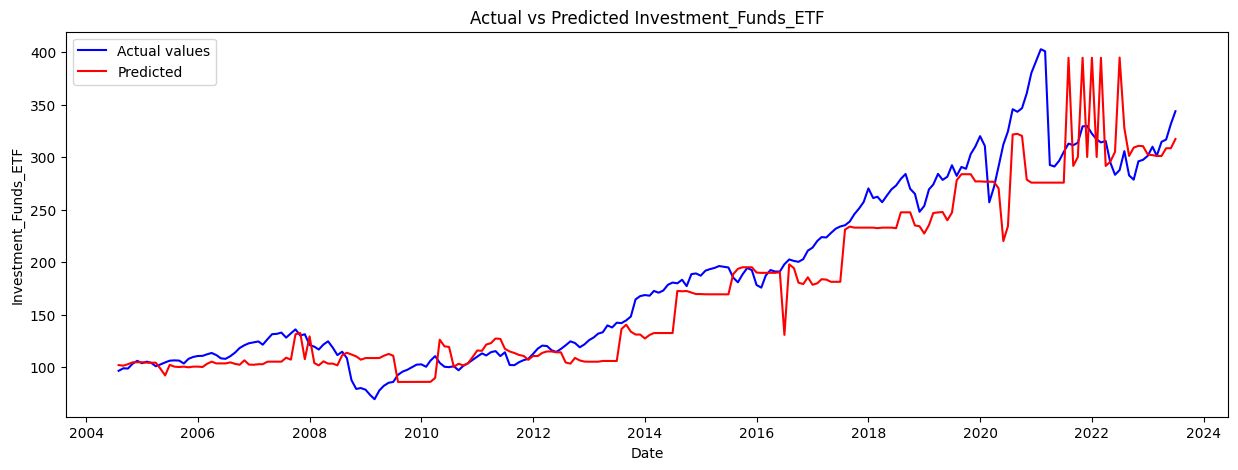

                         Feature  Importance
6   Restaurant_FastFood_ETF_lag1    0.236519
0        Agri_Machinery_ETF_lag1    0.156309
3         Food_Beverage_ETF_lag1    0.123118
5         Food_Beverage_ETF_lag3    0.119952
4         Food_Beverage_ETF_lag2    0.094323
8   Restaurant_FastFood_ETF_lag3    0.072471
9                Retail_ETF_lag1    0.056032
2        Agri_Machinery_ETF_lag3    0.047333
1        Agri_Machinery_ETF_lag2    0.025989
11               Retail_ETF_lag3    0.025551
7   Restaurant_FastFood_ETF_lag2    0.024381
10               Retail_ETF_lag2    0.018022


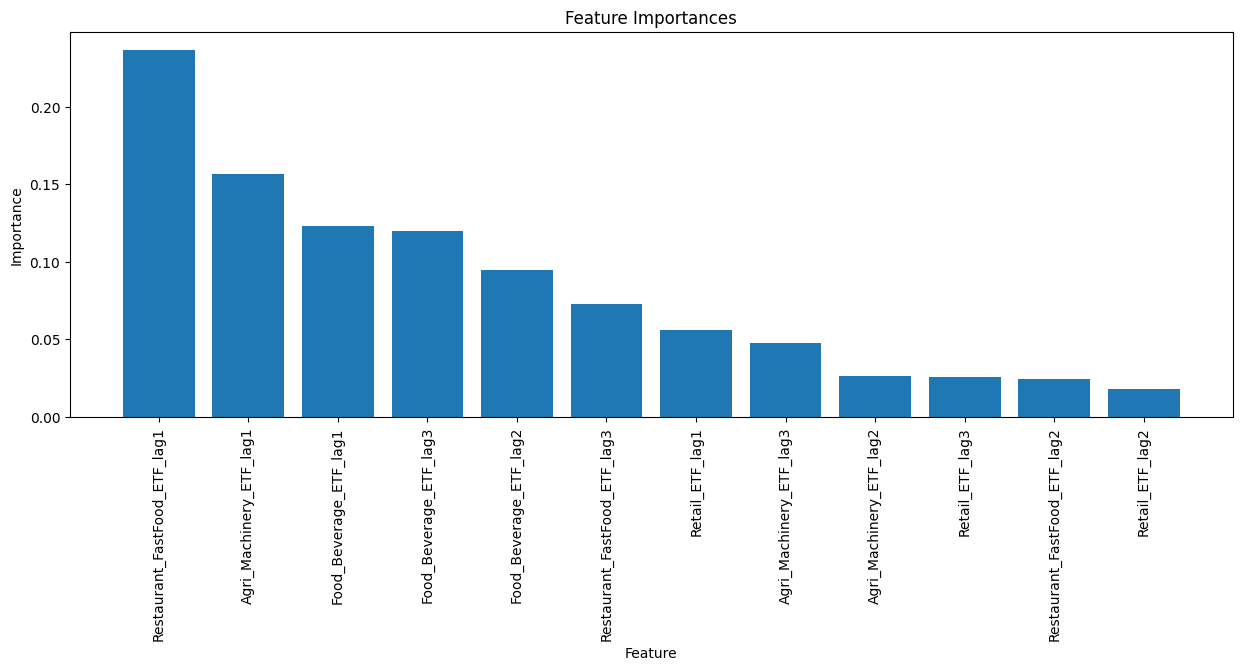

In [15]:
from xgboost import XGBRegressor
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

def train_xgboost(data, target, n_train=36, n_test=12):
    features = ['Agri_Machinery_ETF', 'Food_Beverage_ETF', 'Restaurant_FastFood_ETF', 'Retail_ETF']

    data['Date'] = pd.to_datetime(data[['Year', 'Month']].assign(DAY=1))

    data[features + [target]] = data[features + [target]].astype(float)

    # Create lagged features
    def add_lagged_features(df, features, lags=[1, 2, 3]):
        for lag in lags:
            for feature in features:
                df[f'{feature}_lag{lag}'] = df[feature].shift(lag)
        return df

    lags = [1, 2, 3]
    data = add_lagged_features(data, features, lags)

    data.dropna(inplace=True)

    lagged_features = [f'{feature}_lag{lag}' for feature in features for lag in lags]

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data[lagged_features + [target]])

    scaled_df = pd.DataFrame(scaled_data, columns=lagged_features + [target])
    scaled_df['Date'] = data['Date'].values

    def walk_forward_validation(data, n_train, n_test):
        predictions = []
        actuals = []
        dates = []
        feature_importances = []

        for i in range(n_train, len(data) - n_test, n_test):
            train, test = data[i - n_train:i], data[i:i + n_test]
            
            X_train, y_train = train[lagged_features].values, train[target].values
            X_test, y_test = test[lagged_features].values, test[target].values

            model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
            model.fit(X_train, y_train)

            y_pred = model.predict(X_test)

            y_test_inv = scaler.inverse_transform(np.concatenate((np.zeros((len(y_test), len(lagged_features))), y_test.reshape(-1, 1)), axis=1))[:, -1]
            y_pred_inv = scaler.inverse_transform(np.concatenate((np.zeros((len(y_pred), len(lagged_features))), y_pred.reshape(-1, 1)), axis=1))[:, -1]

            predictions.extend(y_pred_inv)
            actuals.extend(y_test_inv)
            dates.extend(test['Date'].values)

            feature_importances.append(model.feature_importances_)

        return np.array(predictions), np.array(actuals), np.array(dates), np.mean(feature_importances, axis=0)

    predictions, actuals, dates, feature_importances = walk_forward_validation(scaled_df, n_train, n_test)

    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actuals, predictions)

    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R-squared (R²): {r2}")

    plt.figure(figsize=(15, 5))
    plt.plot(dates, actuals, color='blue', label='Actual values')
    plt.plot(dates, predictions, color='red', label='Predicted')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel(target)
    plt.title(f'Actual vs Predicted {target}')
    plt.show()

    feature_importance_df = pd.DataFrame({'Feature': lagged_features, 'Importance': feature_importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    print(feature_importance_df)

    plt.figure(figsize=(15, 5))
    plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.xticks(rotation=90)
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.title('Feature Importances')
    plt.show()
    # etf_columns = ['Agri_Machinery_ETF', 'Food_Beverage_ETF', 'Restaurant_FastFood_ETF', 'Retail_ETF']

train_xgboost(etf_df, 'Investment_Funds_ETF')